In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.artifacts.video_artifact import VideoArtifact
import torch

torch.set_grad_enabled(False)

extr_anim_art = AnimationArtifact.from_wandb_artifact_tag('extr_anim:latest')
extr_ims_art = VideoArtifact.from_wandb_artifact_tag('extr_images:latest')

In [31]:
from text3d2video.util import index_list

indices = [0]

extr_seq = extr_anim_art.read_anim_seq(indices)
extr_ims = index_list(extr_ims_art.read_frames(), indices)

In [32]:
from text3d2video.utilities.video_comparison import display_vid, display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip


extr_vid = pil_frames_to_clip(extr_ims)
extr_uvs = pil_frames_to_clip(extr_seq.render_rgb_uv_maps())

display_vids([extr_vid, extr_uvs])

In [33]:
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.rgb_extraction_pipeline import RgbExtractionPipeline

pipe = load_pipeline(RgbExtractionPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
latents = pipe.encode_images(extr_ims)

In [110]:
from text3d2video.inversion import my_inversion

latents = pipe.encode_images(extr_ims)
inverted_trajectory, timesteps = my_inversion(
    pipe, latents, "Deadpool", guidance_scale=7.5, num_inference_steps=100
)

print(timesteps)
print(inverted_trajectory.shape)

100%|██████████| 99/99 [00:05<00:00, 19.28it/s]

tensor([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121, 131,
        141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271,
        281, 291, 301, 311, 321, 331, 341, 351, 361, 371, 381, 391, 401, 411,
        421, 431, 441, 451, 461, 471, 481, 491, 501, 511, 521, 531, 541, 551,
        561, 571, 581, 591, 601, 611, 621, 631, 641, 651, 661, 671, 681, 691,
        701, 711, 721, 731, 741, 751, 761, 771, 781, 791, 801, 811, 821, 831,
        841, 851, 861, 871, 881, 891, 901, 911, 921, 931, 941, 951, 961, 971,
        981, 991], device='cuda:0')
torch.Size([100, 1, 4, 64, 64])


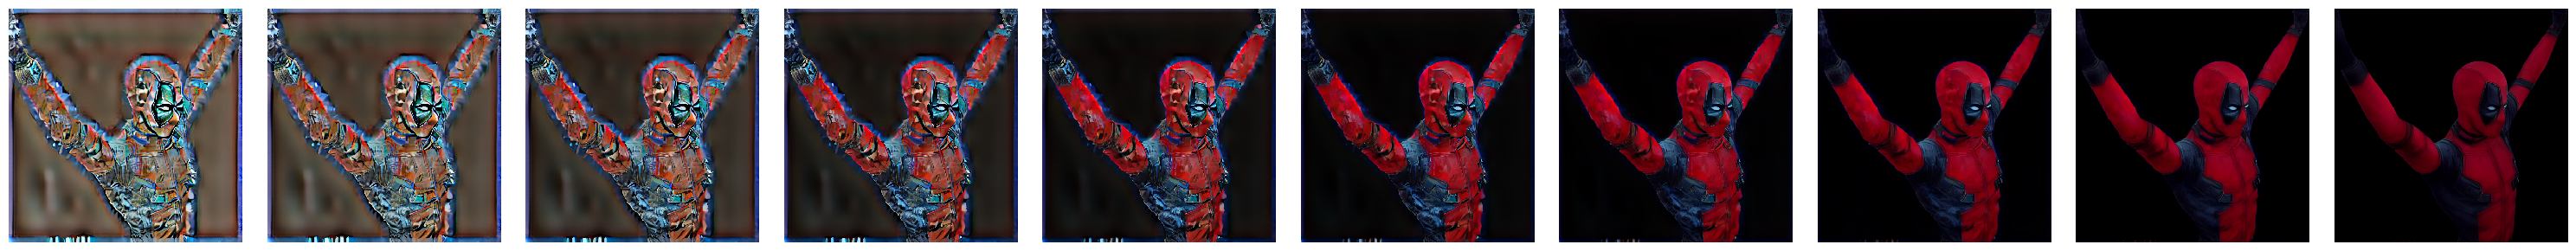

In [111]:
from text3d2video.utilities.ipython_utils import display_ims

pipe.scheduler.set_timesteps(10)
pipe.scheduler.timesteps

t_big = timesteps
t_small = pipe.scheduler.timesteps.cuda()

_, indices = torch.abs(t_big[:, None] - t_small[None, :]).min(dim=0)

reverse_trajectory = inverted_trajectory[indices]

display_ims(pipe.decode_latents(reverse_trajectory[:, 0]))

In [112]:
from text3d2video.utilities.video_comparison import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip

anim = AnimationArtifact.from_wandb_artifact_tag('ymca_20:latest')
seq = anim.read_anim_seq()

display_vid(pil_frames_to_clip(seq.render_rgb_uv_maps()))

In [117]:
from text3d2video.pipelines.rgb_extraction_pipeline import GenerativeRenderingConfig

conf = GenerativeRenderingConfig(num_inference_steps=10, attend_to_self_kv=False)

images = pipe("Deadpool", seq, extr_seq, conf, reverse_trajectory)

100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


In [118]:
display_vid(pil_frames_to_clip(images))

: 